In [14]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
class Ptr_Net(nn.Module):
    def __init__(self,hidden_size=10, embedding_size=10,num_directions=2,
                 input_size=2,batch_size=128,initialization_stddev=0.1):
        super(Ptr_Net, self).__init__()
        #Define Embedded
        self.Embed=torch.nn.Linear(input_size, embedding_size, bias=True)
        #Define Encoder
        self.Encoder=torch.nn.LSTM(input_size=embedding_size,hidden_size=hidden_size,batch_first=True,
                              bidirectional=True)
        #Define Attention
        self.W_ref=torch.nn.Linear(num_directions * hidden_size, num_directions * hidden_size, bias=True)
        self.W_q=torch.nn.Linear(num_directions * hidden_size, num_directions * hidden_size, bias=True)
        self.v=torch.nn.Linear(num_directions * hidden_size, 1, bias=True)
        #Define Decoder
        self.Decoder=torch.nn.LSTM(input_size=embedding_size*2,hidden_size=hidden_size,batch_first=True,
                              bidirectional=True)
        self.Softmax_Cross_Entrophy=torch.nn.CrossEntropyLoss(reduction='none')
    def forward(self, inputs, test_roads):
        #inputs:(batch,city,2),tensor
        #test_roads:(batch,city),numpy
        #output:(batch),tensor
        #basic parameter
        city=inputs.size()[1]
        max_time_steps=inputs.size()[1]
        already_played_penalty=1e6
        #Embedding
        #inputs:(batch,city,coor)
        City_Embedding=self.Embed(inputs)
        #Encoder
        #City_Embedding:(batch,city,embedding)
        Enc, (hn, cn) = self.Encoder(City_Embedding,None)
        #Attention and Decoder
        #Enc:(batch, city, num_directions * hidden_size)
        #hn: (batch,num_layers * num_directions,  hidden_size)
        #cn: (batch,num_layers * num_directions,  hidden_size)
        decoder_input = torch.zeros(Enc.size()[0],1,Enc.size()[2])
        decoder_state = (hn,cn)
        already_played_actions = torch.zeros(Enc.size()[0],max_time_steps)
        decoder_inputs = [decoder_input]
        path_loss=0
        decoder_outputs=[]
        for i in range(max_time_steps):
            decoder_output,decoder_state=self.Decoder(decoder_input,decoder_state)
            attention_weight=torch.nn.functional.softmax(
                torch.squeeze(
                    self.v(torch.tanh(
                        self.W_ref(Enc)+self.W_q(decoder_output.repeat(1,city,1))
                    ))
                )-already_played_penalty*already_played_actions,dim=1
            )
            #attention_weight:(batch,city)
            decoder_outputs.append(torch.argmax(attention_weight, dim=1))
            decoder_input=torch.unsqueeze(torch.einsum('ij,ijk->ik',attention_weight,Enc),dim=1)
            already_played_actions+=torch.zeros(Enc.size()[0],max_time_steps).scatter_(1,torch.unsqueeze(decoder_outputs[-1],dim=1),1)
            path_loss+=self.Softmax_Cross_Entrophy(attention_weight,torch.LongTensor(test_roads[:,i].T).squeeze())
        return path_loss
    def get_road(self,inputs,random=False):
        #inputs:(batch,city,2),tensor
        #output:(batch,city),numpy
        #basic parameter
        city=inputs.size()[1]
        max_time_steps=inputs.size()[1]
        already_played_penalty=1e6
        #Embedding
        #inputs:(batch,city,coor)
        City_Embedding=self.Embed(inputs)
        #Encoder
        #City_Embedding:(batch,city,embedding)
        Enc, (hn, cn) = self.Encoder(City_Embedding,None)
        #Attention and Decoder
        #Enc:(batch, city, num_directions * hidden_size)
        #hn: (batch,num_layers * num_directions,  hidden_size)
        #cn: (batch,num_layers * num_directions,  hidden_size)
        decoder_input = torch.zeros(Enc.size()[0],1,Enc.size()[2])
        decoder_state = (hn,cn)
        already_played_actions = torch.zeros(Enc.size()[0],max_time_steps)
        decoder_inputs = [decoder_input]
        decoder_outputs=[]
        for i in range(max_time_steps):
            decoder_output,decoder_state=self.Decoder(decoder_input,decoder_state)
            #print(decoder_output.size())
            attention_weight=torch.nn.functional.softmax(
                torch.squeeze(
                    self.v(torch.tanh(
                        self.W_ref(Enc)+self.W_q(decoder_output.repeat(1,city,1))
                    ))
                )-already_played_penalty*already_played_actions,dim=1
            )
            #print(attention_weight)
            if random==False:
                decoder_outputs.append(torch.argmax(attention_weight, dim=1))
            else:
                print(attention_weight)
                decoder_outputs.append(torch.argmax(attention_weight, dim=1))
            decoder_input=torch.unsqueeze(torch.einsum('ij,ijk->ik',attention_weight,Enc),dim=1)
            already_played_actions+=torch.zeros(Enc.size()[0],max_time_steps).scatter_(1,torch.unsqueeze(decoder_outputs[-1],dim=1),1)
        return np.array([list(item) for item in decoder_outputs]).T
class Critic_Net(nn.Module):
    def __init__(self,hidden_size=128, embedding_size=128,num_directions=2,
                 input_size=2,batch_size=128,initialization_stddev=0.1,mid_size=100):
        super(Critic_Net, self).__init__()
        #Define Embedded
        self.Embed=torch.nn.Linear(input_size, embedding_size, bias=True)
        #Define Encoder
        self.Encoder=torch.nn.LSTM(input_size=embedding_size,hidden_size=hidden_size,batch_first=True,
                              bidirectional=True)
        #Define Attention
        self.W_ref=torch.nn.Linear(num_directions * hidden_size, num_directions * hidden_size, bias=True)
        self.W_q=torch.nn.Linear(num_directions * hidden_size, num_directions * hidden_size, bias=True)
        self.v=torch.nn.Linear(num_directions * hidden_size, 1, bias=True)
        #Define Decoder
        self.Processor=torch.nn.LSTM(input_size=embedding_size*2,hidden_size=hidden_size,batch_first=True,
                              bidirectional=True)
        self.last_layer=torch.nn.Sequential(
            torch.nn.Linear(embedding_size*2, mid_size, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(mid_size,1, bias=True)
        )
    def forward(self, inputs):
        #inputs:(batch,city,2),tensor
        #output:(batch),tensor
        #basic parameter
        city=inputs.size()[1]
        max_time_steps=inputs.size()[1]
        #Embedding
        #inputs:(batch,city,coor)
        City_Embedding=self.Embed(inputs)
        #Encoder
        #City_Embedding:(batch,city,embedding)
        Enc, (hn, cn) = self.Encoder(City_Embedding,None)
        #Attention and Decoder
        #Enc:(batch, city, num_directions * hidden_size)
        #hn: (batch,num_layers * num_directions,  hidden_size)
        #cn: (batch,num_layers * num_directions,  hidden_size)
        processor_input = torch.zeros(Enc.size()[0],1,Enc.size()[2])
        #processor_input:(batch, city, num_directions * hidden_size)
        processor_state = (hn,cn)
        processor_inputs = [processor_input]
        for i in range(max_time_steps):
            processor_output,processor_state=self.Processor(processor_input,processor_state)
            attention_weight=torch.nn.functional.softmax(
                torch.squeeze(
                    self.v(torch.tanh(
                        self.W_ref(Enc)+self.W_q(processor_output.repeat(1,city,1))
                    ))
                ),dim=1
            )
            processor_input=torch.unsqueeze(torch.einsum('ij,ijk->ik',attention_weight,Enc),dim=1)
        output=torch.squeeze(self.last_layer(processor_output))
        return output
def get_point(batch,city,coor):
    #output:(batch,city,coor),tensor
    return torch.abs(torch.FloatTensor(np.random.normal(size=(batch,city,coor))))
def get_length(point,road):
    #point:(batch,city,coor),tensor
    #road:(batch,city),numpy
    #output:(batch,city),tensor
    try:
        length=torch.zeros(torch.IntTensor(road).size())
    except TypeError:
        length=torch.zeros(torch.LongTensor(road).size())
    batch=length.size()[0]
    city=length.size()[1]
    for i in range(batch):
        for j in range(city):
            if j!=city-1:
                length[i,j]=float(torch.sum(torch.pow(point[i,road[i,j],:]-point[i,road[i,j+1],:],2)))
            else:
                length[i,j]=float(torch.sum(torch.pow(point[i,road[i,j],:]-point[i,road[i,0],:],2)))
    return length
def get_length_sum(point,road):
    #point:(batch,city,coor),tensor
    #road:(batch,city),numpy
    #output:(batch),tensor
    try:
        length=torch.zeros(torch.IntTensor(road).size())
    except TypeError:
        length=torch.zeros(torch.LongTensor(road).size())
    batch=length.size()[0]
    city=length.size()[1]
    for i in range(batch):
        for j in range(city):
            if j!=city-1:
                length[i,j]=float(torch.sqrt(torch.sum(torch.pow(point[i,road[i,j],:]-point[i,road[i,j+1],:],2))))
            else:
                length[i,j]=float(torch.sqrt(torch.sum(torch.pow(point[i,road[i,j],:]-point[i,road[i,0],:],2))))
    return torch.sum(length,dim=1)
def draw(points,roads):
    #point:(batch,city,coor)
    #road:(batch,city)
    batch=min(roads.shape[0],2)
    #print(batch)
    city=len(roads[0])
    fig=plt.figure()
    for j in range(batch):
        ax=plt.subplot(1,batch,j+1)
        point=points[j].numpy()
        road=roads[j]
        for i in range(city-1):
            ax.plot(point[[road[i],road[i+1]],0],point[[road[i],road[i+1]],1],color='b')
        ax.plot(point[[road[city-1],road[0]],0],point[[road[city-1],road[0]],1],color='b')
    #fig.show()
def training(ptr_net,critic_net,batch=3,city=5,coors=2,lr_c = 0.001,lr_p = 0.01,beta1=0.5,
             n_baseline_gradient_steps=5,train_steps=20,fix_point=False,loss_sign=1,policy_only=False,
             show_i_time=10,show_j_time=10,show_j=False,draw=True):
    critic_op=optim.Adam(critic_net.parameters(), lr=lr_c, betas=(beta1, 0.999))
    ptr_op=optim.Adam(ptr_net.parameters(), lr=lr_p, betas=(beta1, 0.999))
    points_test=get_point(batch,city,coors)
    draw_data_length=[]
    draw_data_loss=[]
    draw_data_critic_loss=[]
    for i in range(train_steps):
        if fix_point==False:
            points=get_point(batch,city,coors)
        else:
            points=points_test
        #points:(batch,city,coors)
        roads=ptr_net.get_road(points)
        #roads:(batch,city)
        real_length=get_length_sum(points,roads)
        if policy_only==False:
            for j in range(n_baseline_gradient_steps):
                est_length=critic_net(points)
                critic_loss=torch.sum(torch.pow(est_length-real_length,2))
                draw_data_critic_loss.append(float(critic_loss))
                critic_net.zero_grad()
                critic_loss.backward(retain_graph=True)
                critic_op.step()
                if show_j:
                    if i%show_j_time==0:
                        print('j:'+str(j))
                        print('bsln_error:'+str(critic_loss))
        adv=est_length-real_length
        ptr_loss=loss_sign*torch.dot(ptr_net(points,roads),adv)
        ptr_net.zero_grad()
        ptr_loss.backward(retain_graph=True)
        ptr_op.step()
        roads_test=ptr_net.get_road(points_test)
        draw_data_loss.append(float(
            torch.dot(
                ptr_net(points_test,roads_test),critic_net(points_test)-get_length_sum(points_test,roads_test)
            )
        ))
        draw_data_length.append(float(torch.mean(get_length_sum(points_test,ptr_net.get_road(points_test)))))
        if i%show_i_time==0:
            print('i:'+str(i))
            roads_test=ptr_net.get_road(points_test)
            print(roads_test[0:2])
            #print(ptr_net.Encoder.state_dict())
            #print(ptr_net.state_dict())
            #for item in ptr_net.Encoder.parameters():
            #    print(item.grad,item.size())
            print('ptr_loss:'+str(torch.dot(
                ptr_net(points_test,roads_test),critic_net(points_test)-get_length_sum(points_test,roads_test)
            )))
            print('mean_length:'+str(torch.mean(get_length_sum(points_test,roads_test))))
            print('bsln_error:'+str(
                torch.sum(torch.pow(critic_net(points_test)-get_length_sum(points_test,roads_test),2))
            ))
    if draw==True:
        fig=plt.figure()
        ax1=plt.subplot(1,2,1)
        ax1.plot(draw_data_length)
        ax2=plt.subplot(1,2,2)
        ax2.plot(draw_data_critic_loss)
        #fig.show()
    return (ptr_net,critic_net)
def get_length_sum_single(point,road):
    #point:(city,coor),tensor
    #road:(city),numpy
    #output:number
    point=torch.FloatTensor(point)
    city=point.size()[0]
    length=0
    for j in range(city):
        if j!=city-1:
            length+=float(torch.sqrt(torch.sum(torch.pow(point[road[j],:]-point[road[j+1],:],2))))
        else:
            length+=float(torch.sqrt(torch.sum(torch.pow(point[road[j],:]-point[road[0],:],2))))
    print(length)
    return length
def draw_single(points,roads):
    #point:(city,coor)
    #road:(city)
    city=len(roads)
    fig=plt.figure()
    ax=plt.subplot(1,1,1)
    point=points[j].numpy()
    road=roads[j]
    for i in range(city-1):
        ax.plot(point[[road[i],road[i+1]],0],point[[road[i],road[i+1]],1],color='b')
    ax.plot(point[[road[city-1],road[0]],0],point[[road[city-1],road[0]],1],color='b')
    #fig.show()
def city_shuffle(points):
    '''
    points:(batch,city,coor)
    shuffle along the city dimension
    each example in batch shuffle in a different way
    '''
    batch_size=points.size()[0]
    city=points.size()[1]
    for i in range(batch_size):
        shuffle=c=torch.randperm(city)
        points[i,:,:]=points[i,shuffle,:]
    return points
def adjust_road(road_shuffle,point_shuffle,point):
    '''
    road_shuffle:(city),numpy
    point_shuffle:(city,coor),tensor
    point:(city,coor),tensor
    '''
    city=road_shuffle.shape[0]
    road=[]
    for i in range(city):
        point_now=point_shuffle[i]
        for j in range(city):
            if torch.all(torch.eq(point_now,point[j])):
                road.append(j)
                break
    return np.array(road)
def active_search(ptr_net,point,road=None,iter_time=300,batch_size=300,
                  lr_p = 0.01,beta1=0.5,alpha=0.01,loss_sign=1,alpha_decay=0.9,
                 plot_comp=True,plot_mean=False):
    '''
    searching for shortest road for a particular points distribution
    point:(city,coor),tensor
    road:(city),numpy
    '''
    ptr_op=optim.Adam(ptr_net.parameters(), lr=lr_p, betas=(beta1, 0.999))
    point_copy=torch.unsqueeze(point,0).repeat(batch_size,1,1)
    if road is None:
        road=ptr_net.get_road(point_copy)[0]
    city=road.shape[0]
    road=torch.IntTensor(road)
    road_copy=torch.unsqueeze(road,0).repeat(batch_size,1)
    road_best=road_copy[0]
    #point_copy:(batch,city,coor),tensor
    #road_copy:(batch,city),tensor
    #road_best:(city)
    length_best=get_length_sum(point_copy,road_copy)[0]
    #length_best:number
    baseline=length_best
    mean=[]
    #length_best:number
    for i in range(iter_time):
        point_input=city_shuffle(point_copy)
        road_output=ptr_net.get_road(point_input)
        length_all=get_length_sum(point_input,road_output)
        #length_all:(batch)
        j=torch.argmin(length_all)
        if length_all[j]<length_best:
            length_best=length_all[j]
            road_shuffle=road_output[j,:]
            point_shuffle=point_input[j]
            #print(get_length_sum_single(point_shuffle,road_shuffle))
            road_best=adjust_road(road_shuffle,point_shuffle,point)
        adv=baseline-length_all
        ptr_loss=loss_sign*torch.dot(ptr_net(point_input,road_output),adv)
        ptr_net.zero_grad()
        ptr_loss.backward(retain_graph=True)
        ptr_op.step()
        if i%10==0:
            print(i)
        mean.append(float((torch.mean(length_all))))
        baseline=baseline*alpha_decay+(1-alpha_decay)*torch.mean(length_all)
    fig=plt.figure()
    if plot_comp==True:
        point=point.numpy()
        fig1,ax=plt.subplots(1,2)
        ax_init=ax[0]
        ax_init.set_title('init:'+str(round(float(get_length_sum(point_copy,road_copy)[0]),4)), 
                          fontsize=14, fontweight='bold')
        for i in range(city-1):
            ax_init.plot(point[[road[i],road[i+1]],0],point[[road[i],road[i+1]],1],color='b')
        ax_init.plot(point[[road[city-1],road[0]],0],point[[road[city-1],road[0]],1],color='b')
        road_best_copy=torch.unsqueeze(torch.IntTensor(road_best),0).repeat(batch_size,1)
        ax_after=ax[1]
        ax_after.set_title('after:'+str(round(float(get_length_sum_single(point,road_best)),4)), 
                          fontsize=14, fontweight='bold')
        for i in range(city-1):
            ax_after.plot(point[[road_best[i],road_best[i+1]],0],point[[road_best[i],road_best[i+1]],1],color='b')
        ax_after.plot(point[[road_best[city-1],road_best[0]],0],point[[road_best[city-1],road_best[0]],1],color='b')
    elif plot_mean==True:
        plt.plot(mean)
    return {
        'mean':mean,
        'road_best':road_best,
        'length_best':length_best
    }

mean_length_before_training:tensor(15.4640)
length_real_of_picture_before_training:[10.853312 11.877684]
est_real_of_picture_before_training:[-0.02209678 -0.02040035]


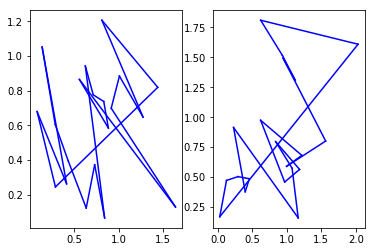

In [99]:
ptr_net1=Ptr_Net()
ptr_net2=Ptr_Net()
critic_net=Critic_Net()
points=get_point(100,20,2)
#data visualization before training
roads=ptr_net1.get_road(points)
print('mean_length_before_training:'+str(torch.mean(get_length_sum(points,roads))))
print('length_real_of_picture_before_training:'+str(get_length_sum(points,roads).numpy()[0:2]))
print('est_real_of_picture_before_training:'+str(critic_net(points).detach().numpy()[0:2]))
draw(points,roads)

In [ ]:
ptr_net1,critic_net=training(ptr_net1,critic_net,batch=128,city=20,coors=2,lr_c = 0.001,lr_p = 0.001,beta1=0.9,
                    n_baseline_gradient_steps=1,train_steps=5000,show_i_time=10,show_j_time=10,show_j=False)

i:0
[[19 10 13 14 12  2 11  6  0  1  7  4  9 15  5 18  3  8 17 16]
 [19 18 17 16 15 14  1  3  0 13 11  8 10  2 12  7  4  5  6  9]]
ptr_loss:tensor(-5340.3789, grad_fn=<DotBackward>)
mean_length:tensor(17.3282)
bsln_error:tensor(1182.3147, grad_fn=<SumBackward0>)
i:10
[[19 10 13  0 14  6  2  7 12 11 18  1  8  9  4  3 17  5 15 16]
 [19 18 17 16 15 14 13  1  0  3 12 11  2 10  8  6  5  7  4  9]]
ptr_loss:tensor(9937.4258, grad_fn=<DotBackward>)
mean_length:tensor(18.2506)
bsln_error:tensor(1673.8674, grad_fn=<SumBackward0>)
i:20
[[19 10 13 14  6 12  2 11  7  0  1 18  4  8  9  5 15  3 17 16]
 [19 18 17 16 15 14  1  3 13  0 11 12  8 10  2  5  6  7  4  9]]
ptr_loss:tensor(-4374.7529, grad_fn=<DotBackward>)
mean_length:tensor(17.6106)
bsln_error:tensor(1222.6421, grad_fn=<SumBackward0>)
i:30
[[19  0 17 18  9  1  2 10 16 11  5 12  3  4 14  6 13 15  8  7]
 [19 18 17 16  0 15  1 14  3 11 13  2  8 10  7  4  9  5 12  6]]
ptr_loss:tensor(8879.1992, grad_fn=<DotBackward>)
mean_length:tensor(18.7263)


ptr_loss:tensor(-6596.7700, grad_fn=<DotBackward>)
mean_length:tensor(20.1463)
bsln_error:tensor(411.8108, grad_fn=<SumBackward0>)
i:320
[[19 18 12 10 11 13 14  9 17 15 16  4  6  5  8  2  3  7  1  0]
 [19 18 17 16 15 14 13 11 10  3  8  7  9 12  6  5  4  2  1  0]]
ptr_loss:tensor(-2356.9292, grad_fn=<DotBackward>)
mean_length:tensor(19.4975)
bsln_error:tensor(391.2040, grad_fn=<SumBackward0>)
i:330
[[19 18 12 11 10 14 13 17 15  9 16  4  5  2  6  3  8  7  1  0]
 [19 18 17 16 15 14 11 13 10  3  8  7  9  6  4 12  5  2  1  0]]
ptr_loss:tensor(-146.7849, grad_fn=<DotBackward>)
mean_length:tensor(19.1502)
bsln_error:tensor(328.6706, grad_fn=<SumBackward0>)
i:340
[[19 18 12 11 10 14 13 15  9  4 17 16  2  5  6  3  8  7  1  0]
 [19 18 17 16 15 14 11 13 10  3  8  7  9  6  4  5 12  2  1  0]]
ptr_loss:tensor(95.1984, grad_fn=<DotBackward>)
mean_length:tensor(18.9351)
bsln_error:tensor(328.9079, grad_fn=<SumBackward0>)
i:350
[[19 18 12 11 10 14 13 15  4  9  6 16  2  8 17  5  3  7  1  0]
 [19 18 17 1

bsln_error:tensor(462.1610, grad_fn=<SumBackward0>)
i:630
[[18 19  8 13 10 12  6 14 11  7  5 17 15 16  4  3  9  2  1  0]
 [19 18 17 16 15  9 12 10 14  6 11 13  8  5  7  4  3  2  1  0]]
ptr_loss:tensor(-6753.5786, grad_fn=<DotBackward>)
mean_length:tensor(19.9166)
bsln_error:tensor(548.0681, grad_fn=<SumBackward0>)
i:640
[[18 19 17  8 12 16  5 10 13 11  6 15 14  4  3  9  7  2  1  0]
 [19 18 17 16  9 15 10  6 14 11  8  7 12  5 13  4  3  2  1  0]]
ptr_loss:tensor(6249.9092, grad_fn=<DotBackward>)
mean_length:tensor(20.3842)
bsln_error:tensor(432.9912, grad_fn=<SumBackward0>)
i:650
[[18 19 17 16  8  5 12 15 11  3 10  4 13 14  9  6  7  2  1  0]
 [19 18 17 16  9 10 15  6  8  7 11 14  5  4 12 13  3  2  1  0]]
ptr_loss:tensor(-3894.3940, grad_fn=<DotBackward>)
mean_length:tensor(20.1974)
bsln_error:tensor(466.9294, grad_fn=<SumBackward0>)
i:660
[[18 19 17 16  5  8 15  3 12  4 11  9 14 10 13  6  7  2  1  0]
 [19 18 17  9 16 10 15  6  8  7 11 14  5  4 13 12  3  2  1  0]]
ptr_loss:tensor(3239.941

i:940
[[18 19  8 14 12 15 13 11  4 10 16  6  3  5  7 17  2  9  1  0]
 [19 18 17 16  9 15 10  6  8 14 11  5  7  4 12 13  3  2  1  0]]
ptr_loss:tensor(1222.9756, grad_fn=<DotBackward>)
mean_length:tensor(20.1931)
bsln_error:tensor(374.0289, grad_fn=<SumBackward0>)
i:950
[[18 19  8 15 14 12 16  4 11 13 10  3  5  6 17  7  2  9  1  0]
 [19 18 17 16  9 15 10  8  6 11 14  7  5  4 13  3 12  2  1  0]]
ptr_loss:tensor(-824.1773, grad_fn=<DotBackward>)
mean_length:tensor(20.2078)
bsln_error:tensor(386.8050, grad_fn=<SumBackward0>)
i:960
[[18 19  8 15 14 12 13  4 11 16 10  3  6  5  7 17  2  9  1  0]
 [19 18 17  9 16 15 10  8  6 11 14  5  7  4 13 12  3  2  1  0]]
ptr_loss:tensor(2522.7695, grad_fn=<DotBackward>)
mean_length:tensor(20.3522)
bsln_error:tensor(460.5673, grad_fn=<SumBackward0>)
i:970
[[18 19  8 14 13 12 15 11 10  4  6 16  7  3  5 17  2  9  1  0]
 [19 18 17 16  9 15 10  6  8 14 11  5  4  7 12 13  3  2  1  0]]
ptr_loss:tensor(-3598.1062, grad_fn=<DotBackward>)
mean_length:tensor(20.0447)

ptr_loss:tensor(7653.1299, grad_fn=<DotBackward>)
mean_length:tensor(19.5168)
bsln_error:tensor(470.6861, grad_fn=<SumBackward0>)
i:1260
[[18 19  8 15 12 14 16  4 11 13  5 10  3  6 17  7  2  9  1  0]
 [19 18 17 16  9 15 10  8 11 14  7  6  4  5  3 13 12  2  1  0]]
ptr_loss:tensor(-3437.7297, grad_fn=<DotBackward>)
mean_length:tensor(20.2817)
bsln_error:tensor(391.3341, grad_fn=<SumBackward0>)
i:1270
[[18 19  8 15 16  4 12 14 11  5  3 17 13 10  6  9  2  7  1  0]
 [19 18 17  9 16 10 15  8  7 11  6 14  4  5  3 13 12  2  1  0]]
ptr_loss:tensor(-918.3837, grad_fn=<DotBackward>)
mean_length:tensor(20.3987)
bsln_error:tensor(348.1760, grad_fn=<SumBackward0>)
i:1280
[[18 19  8 15 16  4 12 14 11  5  3 17 13 10  6  9  7  2  1  0]
 [19 18  9 17 16 10 15  8  6  7 11  5  4 14 13 12  3  2  1  0]]
ptr_loss:tensor(-475.7343, grad_fn=<DotBackward>)
mean_length:tensor(20.5193)
bsln_error:tensor(422.2642, grad_fn=<SumBackward0>)
i:1290
[[18 19  8 15 12 14 16  4 11 13  5  3 10  6 17  7  9  2  1  0]
 [19 18

bsln_error:tensor(385.2209, grad_fn=<SumBackward0>)
i:1570
[[18 13 19 14 12 10 11 15  6  4 16  7  8  5  3  2 17  9  1  0]
 [19 18 17 16 15  9 10  8 11 14  6  5 12  4  7 13  3  2  1  0]]
ptr_loss:tensor(2040.8538, grad_fn=<DotBackward>)
mean_length:tensor(19.2052)
bsln_error:tensor(353.0690, grad_fn=<SumBackward0>)
i:1580
[[19 13 14 12 10 11 15  6  4 18 16  5  7  8  3  2 17  9  1  0]
 [19 18 17 16 15  9 10  8 11 14  7  4  6  5 13  3 12  2  1  0]]
ptr_loss:tensor(959.4808, grad_fn=<DotBackward>)
mean_length:tensor(19.2730)
bsln_error:tensor(345.7032, grad_fn=<SumBackward0>)
i:1590
[[19 18 13 14 12 15 11 16  4 10  5 17  6  3  2  8  9  7  1  0]
 [19 18 17 16 15 10  8  9 11 14  7  3  4  5  6 13 12  2  1  0]]
ptr_loss:tensor(346.1569, grad_fn=<DotBackward>)
mean_length:tensor(19.7559)
bsln_error:tensor(362.9429, grad_fn=<SumBackward0>)
i:1600
[[19 18 15 16  4 17 12 11 14  5  3 10 13  9  8  6  2  7  1  0]
 [19 18 17 16 15  9 10  8  7 11 14  4  6  3  5 13 12  2  1  0]]
ptr_loss:tensor(2853.611

bsln_error:tensor(345.3832, grad_fn=<SumBackward0>)
i:1880
[[18 19 13 14 16 15 17  4 12  5 11 10  3  6  8  9  7  2  1  0]
 [19 18 17 16  9 15 10  8 11  7 14  6  4  5 12  3 13  2  1  0]]
ptr_loss:tensor(4014.9309, grad_fn=<DotBackward>)
mean_length:tensor(20.1072)
bsln_error:tensor(426.1247, grad_fn=<SumBackward0>)
i:1890
[[18 19 16 15 17  4  5 14  3 11 12 10  9 13  8  6  2  7  1  0]
 [19 18 17 16  9  8 10 15  7 11 14  6  4  3  5 13 12  2  1  0]]
ptr_loss:tensor(-5889.0483, grad_fn=<DotBackward>)
mean_length:tensor(19.9773)
bsln_error:tensor(384.8506, grad_fn=<SumBackward0>)
i:1900
[[18 19 13 16 15 17  4 14  5 11  3 12 10  8  9  6  2  7  1  0]
 [19 18 17 16  9 15  8 10  7 11 14  6  4  5  3 12 13  2  1  0]]
ptr_loss:tensor(2223.3506, grad_fn=<DotBackward>)
mean_length:tensor(20.2500)
bsln_error:tensor(247.8675, grad_fn=<SumBackward0>)
i:1910
[[18  7 19 13 16 15 17 14  4 10 12  5 11  3  8  6  9  2  1  0]
 [19 12 18 17 16  9 15 10  8  6  7 11 14  5  4 13  3  2  1  0]]
ptr_loss:tensor(296.4

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
38.772429674863815


<Figure size 432x288 with 0 Axes>

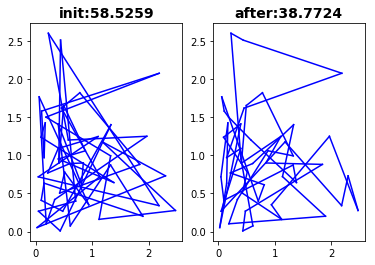

In [97]:
point=get_point(5,50,2)[0]
active_search(ptr_net,point,plot_comp=True,plot_mean=True)

In [27]:
t=torch.tensor([[1,2],[3,4]])
r=torch.randperm(2)
c=torch.randperm(2)
t=t[r][:,c]
r

tensor([1, 0])

In [28]:
t

tensor([[3, 4],
        [1, 2]])